# Preventive to Predictive Maintenance




The Data is downloaded form  [Kaggel](https://www.kaggle.com/datasets/prognosticshse/preventive-to-predicitve-maintenance).

This data set originates from a practice-relevant degradation process, which is representative for Prognostics and Health Management (PHM) applications. The observed degradation process is the clogging of filters when separating of solid particles from gas. A test bench is used for this purpose, which performs automated life testing of filter media by loading them. For testing, dust complying with ISO standard 12103-1 and with a known particle size distribution is employed. The employed filter media is made of randomly oriented non-woven fibre material.

To test the life time of a filter a dust air  is directed through the filter. The flow rate and the differential pressure across the filter are recorded during a lifetime test. The filter failure occurs when the differential pressure across the filter exceeds 600 Pa. However, In practice, the preventive maintenance  causes to replace a filer after a fixed period of time, regardless of the condition of the degrading part. The objective of the data set is to precisely predict the remaining useful life (RUL) of the filter for the given test data, so a transition to predictive maintenance is made possible.

The data is consist of Two file Test_Data_CSV.csv and Train_Data_CSV.csv. The dataset contains training and test data, consisting both of 50 life tests respectively. The test data contains the RUL as a ground truth to the prediction task.

In [248]:
#the used packages
from warnings import filterwarnings
filterwarnings("ignore")

# data visualisation and manipulation
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import random


# Data preparation.
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import  LabelEncoder
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

#regression
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV


# Evaluation.
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression

In [249]:
#loading the data
Test_Data_df=pd.read_csv('data/filters/Test_Data_CSV.csv')
Train_Data_df=pd.read_csv('data/filters/Train_Data_CSV.csv')

# Helper function

In [250]:
def x_reshape(df, columns, sequence_length):
    '''
    This function reshape the data in the given DataFrame by creating subsequences based on the given columns and the sequence length.  It uses a generator to yield consecutive subsequences of the data.
    '''
    data = df[columns].values
    num_elements = data.shape[0]
    for start, stop in zip(range(0, 
                                 num_elements-sequence_length), 
                           range(sequence_length+1,
                                 num_elements)):
        yield(data[start:stop, :])

In [251]:
def make_categori_encode(column):
    '''
    This function changes the data type of a given column to a categorical type and then encodes the categories using the sklearn LabelEncoder. It also prints the encoding map showing the mapping between original labels and their corresponding encoded values.
    '''
    column = pd.Categorical(column)
    label_encoder = LabelEncoder()
    label_encoder.fit(column)
    encoded_column = label_encoder.transform(column)
    la_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print('Label enconding:',la_name_mapping)
    return encoded_column

In [252]:
def creat_feature(df, feature_column):
    '''
    This function utilizes the x_reshape function to generate subsequences of a specified feature column from the input DataFrame.
    The subsequences are then structured into a new DataFrame along with additional metadata such as 'Data_No', 'Dust', 'Dust_feed', and 'Flow_rate_category'. 
    '''
    df_feature = pd.DataFrame(columns = ['Data_No','Dust','Dust_feed','Flow_rate_category','DP_t','DP_t+1','DP_t+2','DP_t+3','DP_t+4','DP_t+5','DP_t+6','DP_t+7','DP_t+8','DP_t+9','DP_t10'])
    for i in range(1,df['Data_No'].nunique() + 1):
        arr= [list(x_reshape(df[df['Data_No'] == i], feature_column, 10))]
        feature_array = np.concatenate(list(arr), axis=0).astype(np.float64)
        feature_array= np.squeeze(feature_array, axis=2)
        df_feature_Data_No = pd.DataFrame(feature_array, columns = ['DP_t','DP_t+1','DP_t+2','DP_t+3','DP_t+4','DP_t+5','DP_t+6','DP_t+7','DP_t+8','DP_t+9','DP_t10'])
        df_feature_Data_No.insert(0, 'Data_No', i)
        df_feature_Data_No.insert(1, 'Dust',df['Dust'][df['Data_No'] == i].iloc[0] )
        df_feature_Data_No.insert(2, 'Dust_feed', df['Dust_feed'][df['Data_No'] == i].iloc[0])
        df_feature_Data_No.insert(3, 'Flow_rate_category', df['Flow_rate_category'][df['Data_No'] == i].iloc[0])        
        df_feature=df_feature.append(df_feature_Data_No, ignore_index = True)  
    return df_feature
    

# Data understading

## The Train Data

In [253]:
Train_Data_df.head(5)

,Data_No,Differential_pressure,Flow_rate,Time,Dust_feed,Dust
0,1,0.0,0.0,0.1,236.428943,"ISO 12103-1, A3 Medium Test Dust"
1,1,0.0,0.0,0.2,236.428943,"ISO 12103-1, A3 Medium Test Dust"
2,1,0.0,0.0,0.3,236.428943,"ISO 12103-1, A3 Medium Test Dust"
3,1,0.0,0.0,0.4,236.428943,"ISO 12103-1, A3 Medium Test Dust"
4,1,0.0,0.0,0.5,236.428943,"ISO 12103-1, A3 Medium Test Dust"


In [254]:
Train_Data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39420 entries, 0 to 39419
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Data_No                39420 non-null  int64  
 1   Differential_pressure  39420 non-null  float64
 2   Flow_rate              39420 non-null  float64
 3   Time                   39420 non-null  float64
 4   Dust_feed              39420 non-null  float64
 5   Dust                   39420 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 1.8+ MB


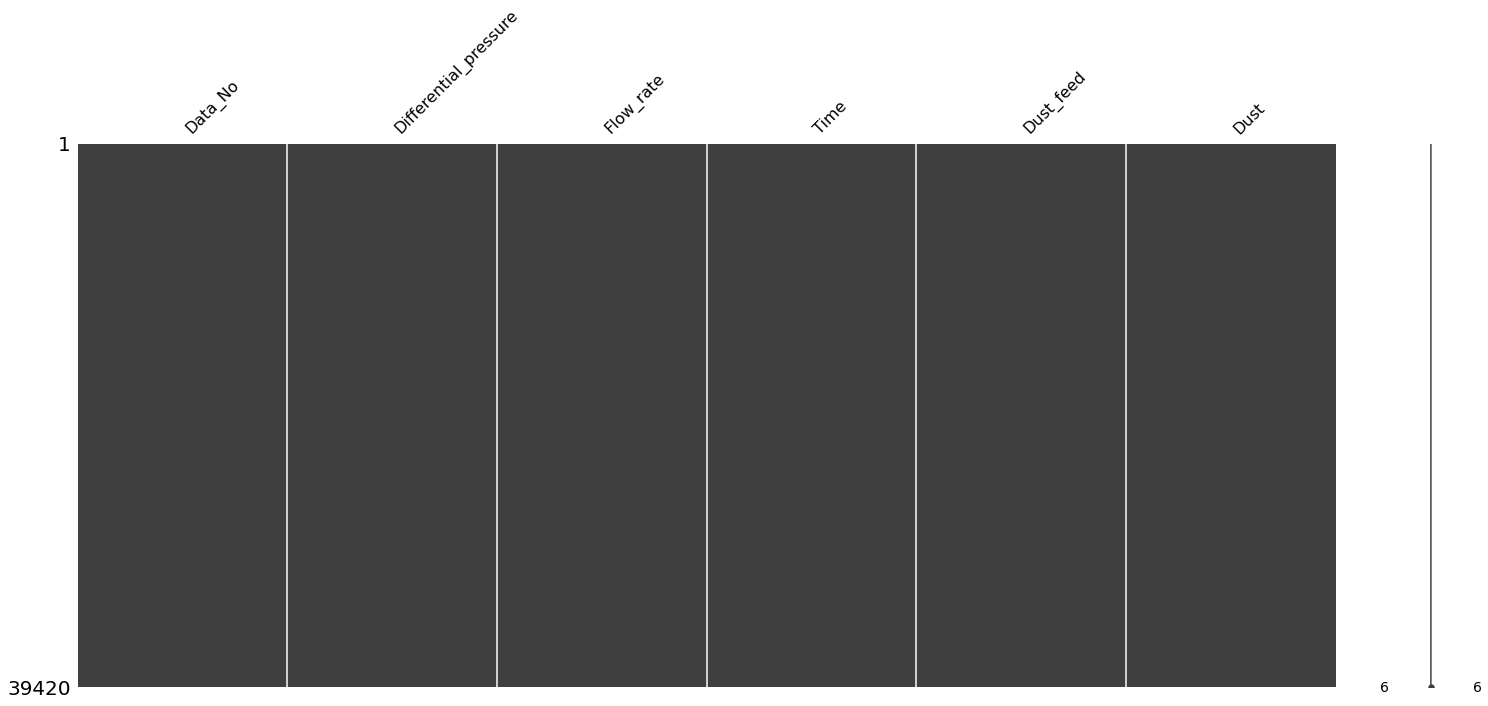

In [255]:
msno.matrix(Train_Data_df); # vislualzing null values # no null values

In [256]:
if  Train_Data_df[Train_Data_df.duplicated()].empty:
    print('No duplicated data in the train data')
else: 
    print(Train_Data_df[Train_Data_df.duplicated()])

No duplicated data in the train data


In [257]:
Train_Data_df["Data_No"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

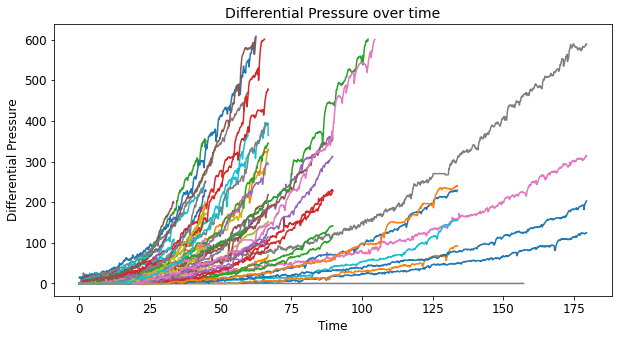

In [258]:
filtergroups = Train_Data_df.groupby(["Data_No"],sort=True)
plt.figure(figsize = (10,5));
for data_no, group in filtergroups:
    plt.plot(group['Time'], group['Differential_pressure']);
    
plt.xlabel('Time', fontsize=12);
plt.ylabel('Differential Pressure', fontsize=12);
plt.tick_params(axis='both', labelsize=12);
plt.title('Differential Pressure over time', fontsize=14);

The differential_pressure increase with time. Five filters reach the differential_pressure = 600 Pa.  The differential_pressure is less than 300 Pa for most of the filters.

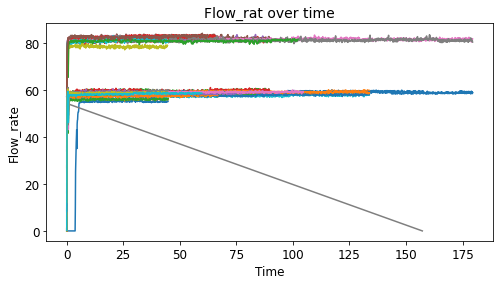

In [259]:
plt.figure(figsize = (8,4));
for data_no, group in filtergroups:
    plt.plot(group['Time'], group['Flow_rate']);
    
plt.xlabel('Time', fontsize=12);
plt.ylabel('Flow_rate', fontsize=12);
plt.tick_params(axis='both', labelsize=12);
plt.title('Flow_rat over time', fontsize=14);

The flow rate increase rapidly from zero to a fixed value. There are two diffrent flow rates. The flow rate for one case is droping down, let's figure it out.

In [260]:
print(Train_Data_df[(Train_Data_df['Time']> 100) & (Train_Data_df['Flow_rate'] < 40)])

       Data_No  Differential_pressure  Flow_rate   Time   Dust_feed  \
21194       28                    0.0        0.0  157.2  177.321707   

                                   Dust  
21194  ISO 12103-1, A3 Medium Test Dust  


The flow rate for filter 28 is 0.0 at time 157.2 let's check.

In [261]:
print(Train_Data_df.loc[Train_Data_df['Data_No']==28])

       Data_No  Differential_pressure  Flow_rate   Time   Dust_feed  \
21194       28                 0.0000   0.000000  157.2  177.321707   
21195       28                 0.0000  54.274681    0.2  177.321707   
21196       28                 0.0000  72.217110    0.3  177.321707   
21197       28                 0.0000  79.419242    0.4  177.321707   
21198       28                 0.0000  80.914992    0.5  177.321707   
...        ...                    ...        ...    ...         ...   
21787       28               467.9362  82.709333   59.4  177.321707   
21788       28               466.0373  82.269684   59.5  177.321707   
21789       28               466.0373  82.024495   59.6  177.321707   
21790       28               467.9362  82.743156   59.7  177.321707   
21791       28               471.1010  82.751615   59.8  177.321707   

                                   Dust  
21194  ISO 12103-1, A3 Medium Test Dust  
21195  ISO 12103-1, A3 Medium Test Dust  
21196  ISO 12103-1, A

It seemes that the first recored for the filter 28 is not correct with time 157 and then is the second record 0.2. No problem as we will drop later all rows with flow rate 0 and also the rows where the differential pressure is 0. 

In [262]:
Train_Data_df["Dust_feed"].unique()

array([236.4289432 , 118.2144716 ,  59.1072358 , 158.49253256,
        79.24626628, 316.98506512, 237.73879884, 177.3217074 ])

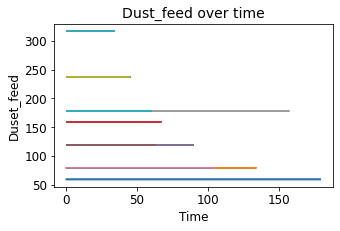

In [263]:
plt.figure(figsize = (5,3));
for data_no, group in filtergroups:
    plt.plot(group['Time'], group['Dust_feed']);
    
plt.xlabel('Time', fontsize=12);
plt.ylabel('Duset_feed', fontsize=12);
plt.tick_params(axis='both', labelsize=12);
plt.title('Dust_feed over time', fontsize=14);

The dust feed has 8 discrete values and it is stable with time.

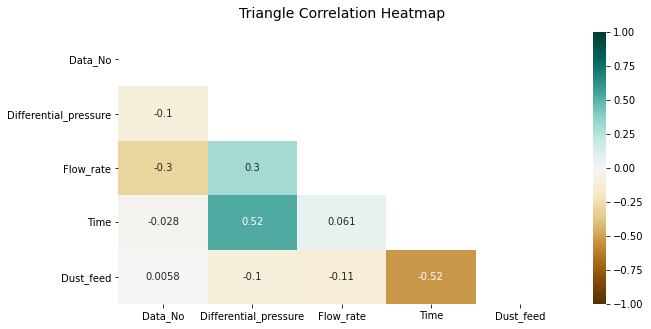

In [264]:
plt.figure(figsize=(10, 5))
mask = np.triu(np.ones_like(Train_Data_df.corr(numeric_only=True), dtype=np.bool))
heatmap = sns.heatmap(Train_Data_df.corr(numeric_only=True), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':14}, pad=14);

There is some small psitive correlation between time and Differential_pressure  and a negative one between time and the Dust_feed as expected. Some correlation between differenial_pressure and the Flow_rate.

In [265]:
Train_Data_df["Dust"].unique()

array(['ISO 12103-1, A3 Medium Test Dust',
       'ISO 12103-1, A2 Fine Test Dust',
       'ISO 12103-1, A4 Coarse Test Dust'], dtype=object)

## The Test Data

In [266]:
Test_Data_df.head(5)

,Data_No,Differential_pressure,Flow_rate,Time,Dust_feed,Dust,RUL
0,1,0.271267,52.281993,0.1,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.9
1,1,0.361690,54.986671,0.2,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.8
2,1,0.000000,55.424786,0.3,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.7
3,1,2.622251,55.524146,0.4,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.6
4,1,3.888165,55.852018,0.5,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.5


In [267]:
Test_Data_df.info()  #There is no null_value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39414 entries, 0 to 39413
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Data_No                39414 non-null  int64  
 1   Differential_pressure  39414 non-null  float64
 2   Flow_rate              39414 non-null  float64
 3   Time                   39414 non-null  float64
 4   Dust_feed              39414 non-null  float64
 5   Dust                   39414 non-null  object 
 6   RUL                    39414 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 2.1+ MB


In [268]:
if  Test_Data_df[Test_Data_df.duplicated()].empty:
    print('No duplicated data in the test data')
else: 
    print(Test_Data_df[Test_Data_df.duplicated()])

No duplicated data in the test data


In [269]:
Test_Data_df["Data_No"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

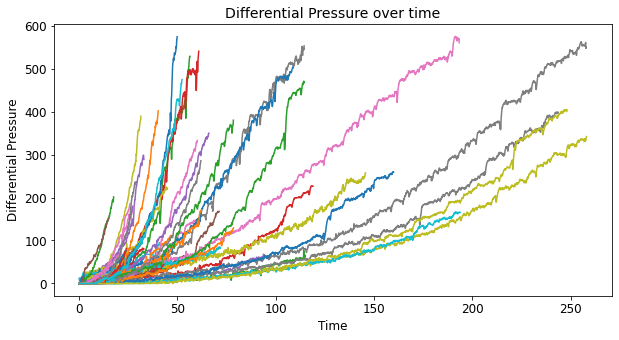

In [270]:
filtergroups = Test_Data_df.groupby(["Data_No"],sort=True)
plt.figure(figsize = (10,5));
for data_no, group in filtergroups:
    plt.plot(group['Time'], group['Differential_pressure']);
    
plt.xlabel('Time', fontsize=12);
plt.ylabel('Differential Pressure', fontsize=12);
plt.tick_params(axis='both', labelsize=12);
plt.title('Differential Pressure over time', fontsize=14);

In test data we can see more filters get close to end life (differentional_presurre a bout 600 Pa). In general the differential_Pressure seemes to reach higher values than in the training data.

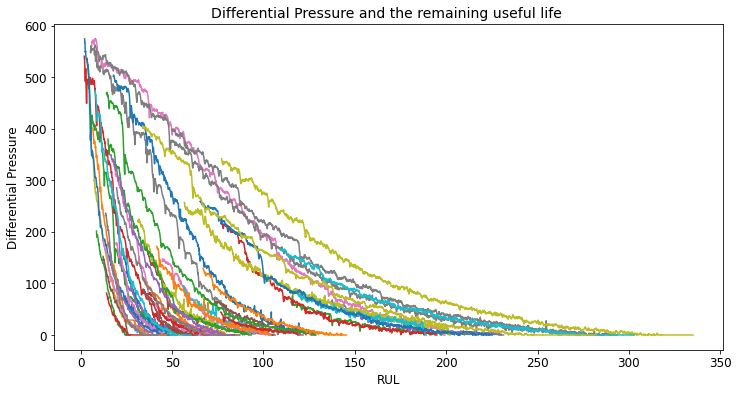

In [271]:
filtergroups = Test_Data_df.groupby(["Data_No"],sort=True)
plt.figure(figsize = (12,6));
for data_no, group in filtergroups:
    plt.plot(group['RUL'], group['Differential_pressure']);
    
plt.xlabel('RUL', fontsize=12);
plt.ylabel('Differential Pressure', fontsize=12);
plt.tick_params(axis='both', labelsize=12);
plt.title('Differential Pressure and the remaining useful life ', fontsize=14);

As expected, in the test data many filters are colse to the end life.

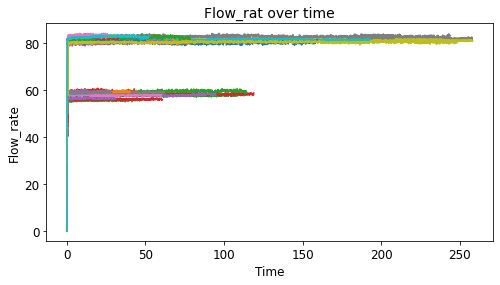

In [272]:
plt.figure(figsize = (8,4));
for data_no, group in filtergroups:
    plt.plot(group['Time'], group['Flow_rate']);
    
plt.xlabel('Time', fontsize=12);
plt.ylabel('Flow_rate', fontsize=12);
plt.tick_params(axis='both', labelsize=12);
plt.title('Flow_rat over time', fontsize=14);

In [273]:
Test_Data_df["Dust_feed"].unique()

array([236.4289432 , 316.98506512, 158.49253256,  79.24626628,
       118.2144716 ,  59.1072358 , 177.3217074 , 237.73879884])

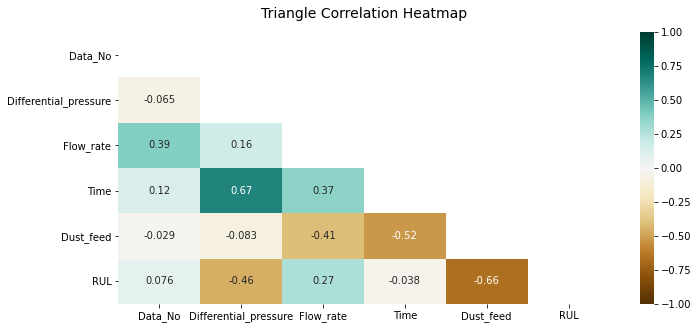

In [274]:
plt.figure(figsize=(11, 5))
mask = np.triu(np.ones_like(Test_Data_df.corr(numeric_only=True), dtype=np.bool))
heatmap = sns.heatmap(Test_Data_df.corr(numeric_only=True), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':14}, pad=14);

We can see in the test data a similar correlation pattern. The RUL has a negiative correlation with the Dust_feed and the differntial-perssure and a small positive correlation  with the flow_rate.

In [275]:
Test_Data_df["Dust"].unique()

array(['ISO 12103-1, A3 Medium Test Dust',
       'ISO 12103-1, A2 Fine Test Dust',
       'ISO 12103-1, A4 Coarse Test Dust'], dtype=object)

# Feature  selecting

Let's first drop the rows where the differential pressure is zero as mentioned earlier.

In [276]:
Train_Data_df.drop(Train_Data_df[Train_Data_df['Differential_pressure'] == 0].index, inplace = True)

Now let's check the autocorrelation.

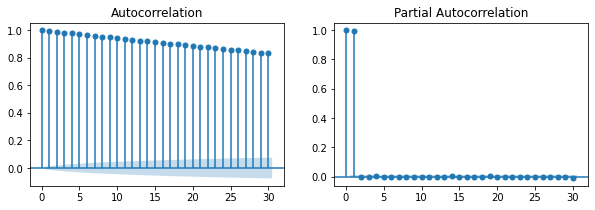

In [277]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 3))
plot_acf(Train_Data_df['Differential_pressure'],lags=30,ax=ax1)
plot_pacf(Train_Data_df['Differential_pressure'],lags=30,ax=ax2)
plt.show()

The autocorrelation is decrease slowly so it is better to see the partial autocorrelation which show that the lag 1 is the most important one.

Let's proceed with categorizing and encoding the columns "Dust" and "Dust_feed," along with the "Flow_rate,". The flow rate as shown earlier has almost a fixed value over time so I will give it two value '0' if it is around 60 and '1' if it is around 80.

In [278]:
Train_Data_df['Dust']=make_categori_encode(Train_Data_df['Dust'])
Train_Data_df['Dust_feed']=make_categori_encode(Train_Data_df['Dust_feed'])


Label enconding: {'ISO 12103-1, A2 Fine Test Dust': 0, 'ISO 12103-1, A3 Medium Test Dust': 1, 'ISO 12103-1, A4 Coarse Test Dust': 2}
Label enconding: {59.1072357995712: 0, 79.2462662797576: 1, 118.214471599142: 2, 158.492532559515: 3, 177.321707398714: 4, 236.428943198285: 5, 237.738798839273: 6, 316.98506511903: 7}


In [279]:
Test_Data_df['Dust']=make_categori_encode(Test_Data_df['Dust'])
Test_Data_df['Dust_feed']=make_categori_encode(Test_Data_df['Dust_feed'])

Label enconding: {'ISO 12103-1, A2 Fine Test Dust': 0, 'ISO 12103-1, A3 Medium Test Dust': 1, 'ISO 12103-1, A4 Coarse Test Dust': 2}
Label enconding: {59.1072357995712: 0, 79.2462662797576: 1, 118.214471599142: 2, 158.492532559515: 3, 177.321707398714: 4, 236.428943198285: 5, 237.738798839273: 6, 316.98506511903: 7}


In [280]:
Train_Data_df['Flow_rate_category']=Train_Data_df.apply(lambda x: 1 if x['Flow_rate']>70 else 0, axis=1)

In [281]:
Test_Data_df['Flow_rate_category']=Test_Data_df.apply(lambda x: 1 if x['Flow_rate']>70 else 0, axis=1)

Now we can creat the features datafame that has:
- The Differential_pressure at time t 'DP_t'
- The Differential_pressure at ten consecutive time points i.e. the differential_pressure for time instances from t+1 to t+10.
- The Dust, Dust_feed and Flow_rate_category.

In [282]:
feature_train = creat_feature(Train_Data_df, ['Differential_pressure'])

In [283]:
feature_train

,Data_No,Dust,Dust_feed,Flow_rate_category,DP_t,DP_t+1,DP_t+2,DP_t+3,DP_t+4,DP_t+5,DP_t+6,DP_t+7,DP_t+8,DP_t+9,DP_t10
0,1,1,5,0,0.271267,0.271267,1.537182,1.537182,1.537182,1.537182,3.345631,5.244502,5.244502,6.419994,6.872107
1,1,1,5,0,0.271267,1.537182,1.537182,1.537182,1.537182,3.345631,5.244502,5.244502,6.419994,6.872107,6.510417
2,1,1,5,0,1.537182,1.537182,1.537182,1.537182,3.345631,5.244502,5.244502,6.419994,6.872107,6.510417,6.510417
3,1,1,5,0,1.537182,1.537182,1.537182,3.345631,5.244502,5.244502,6.419994,6.872107,6.510417,6.510417,6.510417
4,1,1,5,0,1.537182,1.537182,3.345631,5.244502,5.244502,6.419994,6.872107,6.510417,6.510417,6.510417,6.781684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33193,50,2,4,0,335.015200,338.180000,340.169300,345.142500,348.307300,351.472100,355.179400,353.551800,353.280500,355.179400,358.344200
33194,50,2,4,0,338.180000,340.169300,345.142500,348.307300,351.472100,355.179400,353.551800,353.280500,355.179400,358.344200,359.971800
33195,50,2,4,0,340.169300,345.142500,348.307300,351.472100,355.179400,353.551800,353.280500,355.179400,358.344200,359.971800,360.785600
33196,50,2,4,0,345.142500,348.307300,351.472100,355.179400,353.551800,353.280500,355.179400,358.344200,359.971800,360.785600,361.509000


## Data split

Now let's split the features dataframe in to a train and validation data with 85 % for the training. For that I will select randomly  42 filters, or in other words, 42 Data_No, for training and 8 for validation.

In [284]:
seed = 0
np.random.seed(seed)

#Generate 8 random numbers between 1 and 50

randomlist = random.sample(range(1, 50), 8)

In [285]:
train = feature_train[~feature_train['Data_No'].isin(randomlist)]
valid = feature_train[feature_train['Data_No'].isin(randomlist)]


In [286]:
X_train=train.drop(['DP_t10','Data_No'],axis=1)
X_valid=valid.drop(['DP_t10','Data_No'],axis=1)

In [287]:
y_train=train['DP_t10']
y_valid=valid['DP_t10']

# Modeling

In [288]:
class FakeModel:
    
    def __init__(self):
        pass
    
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        return X['DP_t+9'].values

In [289]:
models = [FakeModel(), RandomForestRegressor(), AdaBoostRegressor(), BaggingRegressor(), KNeighborsRegressor()]
model_names=['FakeModel', 'RandomForestRegressor', 'AdaBoostRegressor', 'BaggingRegressor', 'KNeighborsRegressor']
r2=[]
MAE=[]
rmsle=[]
model_evaluation={}
for model in range (len(models)):
    clf=models[model]
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_valid)
    r2.append(r2_score(y_valid,y_pred))
    MAE.append(mean_absolute_error(y_valid,y_pred))
    rmsle.append(np.sqrt(mean_squared_log_error(y_pred,y_valid)))
model_evaluation={'Modelling Algo':model_names,'r2_score':r2,'MAE':MAE,'RMSLE':rmsle} 
model_evaluation=pd.DataFrame(model_evaluation)
model_evaluation


,Modelling Algo,r2_score,MAE,RMSLE
0,FakeModel,0.999786,1.222194,0.075506
1,RandomForestRegressor,0.999738,1.414057,0.076653
2,AdaBoostRegressor,0.995712,6.385928,0.534148
3,BaggingRegressor,0.999704,1.509644,0.082408
4,KNeighborsRegressor,0.999572,1.796500,0.089614


All the models did a great job. let's try some tuning for the  Random Forest Regressor for example. 

### Random Forest Regressor

In [290]:
RF = RandomForestRegressor()
model=RF.fit(X_train, y_train)

In [291]:
start_time= time.process_time()
param = {'bootstrap': [True],'max_depth': [10, 30, 50],'n_estimators': [100, 200, 300],'max_features': ['auto', 'sqrt']}
search = GridSearchCV(RF, param, cv=5, scoring='neg_mean_absolute_error', return_train_score=True)
search.fit(X_valid, y_valid)
end_time= time.process_time()
print('CPU Execution time for searching is  ', (end_time-start_time)/60, 'minutes')

CPU Execution time for searching is   3.2810112392333317 minutes


In [292]:
best_model = search.best_estimator_
best_model

RandomForestRegressor(max_depth=10, max_features='auto', n_estimators=200)

let's evaluate the best tuned model.

In [293]:
RF = best_model
RF.fit(X_train, y_train)
RF_y_pred=RF.predict(X_valid)
r2=r2_score(y_valid,RF_y_pred)
MAE=mean_absolute_error(y_valid,RF_y_pred)
rmsle=np.sqrt(mean_squared_log_error(RF_y_pred,y_valid))
model_evaluation={'r2_score':r2,'MAE':MAE,'RMSLE':rmsle} 
model_evaluation

{'r2_score': 0.9997518622965239,
 'MAE': 1.3565251512768606,
 'RMSLE': 0.07397423254233426}

No much imporving after hyperparamter tuning.

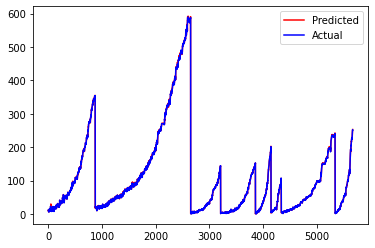

In [294]:
fig, ax = plt.subplots()
ax.plot(RF_y_pred,color='r', label='Predicted');
ax.plot(y_valid.reset_index()['DP_t10'],color='b', label='Actual');
ax.legend()

plt.show()


let's now apply the model in the test data

In [295]:
feature_test= creat_feature(Test_Data_df, ['Differential_pressure'])

In [296]:
filter=3
feature_filter=feature_test[feature_test['Data_No'] == filter]

In [297]:
X=feature_filter.drop(['DP_t10','Data_No'],axis=1)
y_true=feature_filter['DP_t10'].reset_index()

In [298]:
y_pred=RF.predict(X)

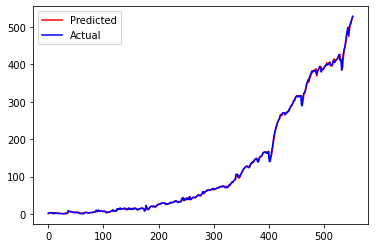

In [299]:
fig, ax = plt.subplots()
ax.plot(y_pred,color='r', label='Predicted');
ax.plot(y_true.reset_index()['DP_t10'],color='b', label='Actual');
ax.legend()

plt.show()


In [300]:
feature_filter.reset_index(inplace=True,drop=True)

In [301]:
feature_filter

,Data_No,Dust,Dust_feed,Flow_rate_category,DP_t,DP_t+1,DP_t+2,DP_t+3,DP_t+4,DP_t+5,DP_t+6,DP_t+7,DP_t+8,DP_t+9,DP_t10
0,3,1,7,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.813802,1.898872
1,3,1,7,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.813802,1.898872,1.898872
2,3,1,7,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,0.000000,0.813802,1.898872,1.898872,3.164786
3,3,1,7,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,0.813802,1.898872,1.898872,3.164786,3.164786
4,3,1,7,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.813802,1.898872,1.898872,3.164786,3.164786,3.345631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,3,1,7,0,447.7720,459.0748,472.5478,480.0528,487.7387,496.509700,478.334700,488.281200,498.408600,504.647700,505.371100
549,3,1,7,0,459.0748,472.5478,480.0528,487.7387,496.5097,478.334700,488.281200,498.408600,504.647700,505.371100,514.775000
550,3,1,7,0,472.5478,480.0528,487.7387,496.5097,478.3347,488.281200,498.408600,504.647700,505.371100,514.775000,518.572800
551,3,1,7,0,480.0528,487.7387,496.5097,478.3347,488.2812,498.408600,504.647700,505.371100,514.775000,518.572800,523.546000


In [302]:
future_step=50
for i in range(future_step+1):
    last_row=feature_filter.values.tolist()[-1]
    values = last_row[:4] + last_row[5 :]+[np.nan]
    feature_filter.loc[len(feature_filter.index)]=values 
    X=feature_filter.tail(1).copy().drop(['DP_t10','Data_No'],axis=1)
    y=RF.predict(X)
    feature_filter['DP_t10'].iloc[-1]=y

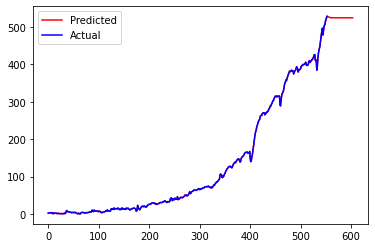

In [303]:
fig, ax = plt.subplots()
ax.plot( feature_filter['DP_t10'],color='r', label='Predicted');
ax.plot(y_true.reset_index()['DP_t10'],color='b', label='Actual');
ax.legend()
plt.show()

 ### KNN

In [304]:
KNN = KNeighborsRegressor()
model2=KNN.fit(X_train, y_train)

In [305]:
KNN_y_pred=KNN.predict(X_valid)
r2=r2_score(y_valid,KNN_y_pred)
MAE=mean_absolute_error(y_valid,KNN_y_pred)
rmsle=np.sqrt(mean_squared_log_error(KNN_y_pred,y_valid))
model_evaluation={'r2_score':r2,'MAE':MAE,'RMSLE':rmsle} 
model_evaluation

{'r2_score': 0.9995720675403996,
 'MAE': 1.7965000866972316,
 'RMSLE': 0.08961427952451222}

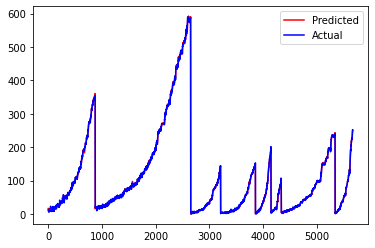

In [306]:
fig, ax = plt.subplots()
ax.plot(KNN_y_pred,color='r', label='Predicted');
ax.plot(y_valid.reset_index()['DP_t10'],color='b', label='Actual');
ax.legend()

plt.show()


let's now apply the model in the test data

In [307]:
feature_test= creat_feature(Test_Data_df, ['Differential_pressure'])

In [308]:
filter=2
feature_filter=feature_test[feature_test['Data_No'] == filter]

In [309]:
X=feature_filter.drop(['DP_t10','Data_No'],axis=1)
y_true=feature_filter['DP_t10'].reset_index()

In [310]:
y_pred=KNN.predict(X)

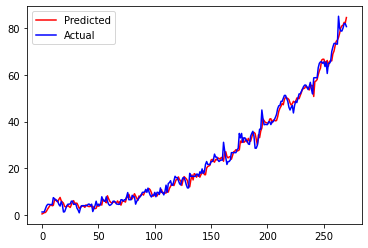

In [311]:
fig, ax = plt.subplots()
ax.plot(y_pred,color='r', label='Predicted');
ax.plot(y_true.reset_index()['DP_t10'],color='b', label='Actual');
ax.legend()

plt.show()


In [312]:
feature_filter.reset_index(inplace=True,drop=True)

In [313]:
feature_filter

,Data_No,Dust,Dust_feed,Flow_rate_category,DP_t,DP_t+1,DP_t+2,DP_t+3,DP_t+4,DP_t+5,DP_t+6,DP_t+7,DP_t+8,DP_t+9,DP_t10
0,2,1,5,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,1.265914
1,2,1,5,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,1.265914,1.265914
2,2,1,5,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,1.265914,1.265914,1.356337
3,2,1,5,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,1.265914,1.265914,1.356337,2.622251
4,2,1,5,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.265914,1.265914,1.356337,2.622251,3.888165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,2,1,5,0,65.73712,69.98698,71.88585,73.42303,73.51345,73.15176,73.151760,85.087530,80.023870,78.757960,78.757960
267,2,1,5,0,69.98698,71.88585,73.42303,73.51345,73.15176,73.15176,85.087530,80.023870,78.757960,78.757960,80.023870
268,2,1,5,0,71.88585,73.42303,73.51345,73.15176,73.15176,85.08753,80.023870,78.757960,78.757960,80.023870,81.922740
269,2,1,5,0,73.42303,73.51345,73.15176,73.15176,85.08753,80.02387,78.757960,78.757960,80.023870,81.922740,81.922740


In [314]:
future_step=100
for i in range(future_step+1):
    last_row=feature_filter.values.tolist()[-1]
    values = last_row[:4] + last_row[5 :]+[np.nan]
    feature_filter.loc[len(feature_filter.index)]=values 
    X=feature_filter.tail(1).copy().drop(['DP_t10','Data_No'],axis=1)
    y=KNN.predict(X)
    feature_filter['DP_t10'].iloc[-1]=y

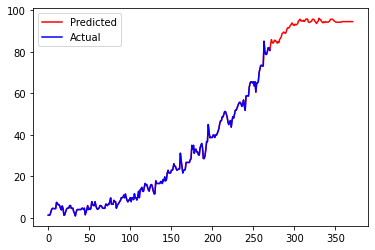

In [315]:
fig, ax = plt.subplots()
ax.plot( feature_filter['DP_t10'],color='r', label='Predicted');
ax.plot(y_true.reset_index()['DP_t10'],color='b', label='Actual');
ax.legend()
plt.show()